In [1]:
%matplotlib inline
import utils
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import librosa
import librosa.display
import missingno as msno 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
# importing warning in order to ignore them
import warnings 
warnings.filterwarnings('always')   #suppresses all warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [3]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/tracks.csv")
genres= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/genres.csv")
features= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/features.csv")
echonest= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/echonest.csv")

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [4]:
regr_tracks=tracks.copy()

# REGRESSION PROBLEM

In [5]:
regr_tracks.shape

(106574, 52)

In [6]:
tracks_cut=['album','artist']
regr_tracks.drop(tracks_cut,axis=1,inplace=True)
regr_tracks.shape

(106574, 22)

In [7]:
regr_tracks=regr_tracks.droplevel(0,axis=1)

In [8]:
tracks_cut=['composer', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'bit_rate','genre_top']
regr_tracks.drop(tracks_cut,axis=1,inplace=True)

In [9]:
regr_tracks

,split,subset,comments,duration,favorites,interest,listens
track_id,,,,,,,
2,training,small,0,168,2,4656,1293
3,training,medium,0,237,1,1470,514
5,training,small,0,206,6,1933,1151
10,training,small,0,161,178,54881,50135
20,training,large,0,311,0,978,361
...,...,...,...,...,...,...,...
155316,training,large,0,162,1,122,102
155317,training,large,0,217,1,194,165
155318,training,large,0,404,2,214,168


In [10]:
target_regr=features[['spectral_rolloff','spectral_centroid']]

In [11]:
target_regr=target_regr.droplevel(0,axis=1)

In [12]:
target_regr.columns=['roll_kurtosis','roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
                   
                   #'bandw_kurtosis','bandw_max','bandw_mean','bandw_median','bandw_min','bandw_skew','bandw_std']
target_regr.head()

,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,
2,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
20,-0.744805,9496.142578,4201.346191,4166.674805,75.366211,0.160345,1495.297119,2.177669,5540.209961,1732.971802,1640.781128,123.611168,0.960959,481.929871


In [13]:
df_regr=pd.merge(regr_tracks,target_regr, on='track_id')

In [14]:
df_regr.drop(index=df_regr[df_regr.subset=='large'].index, inplace=True)

In [15]:
a='listens'
b='favorites'

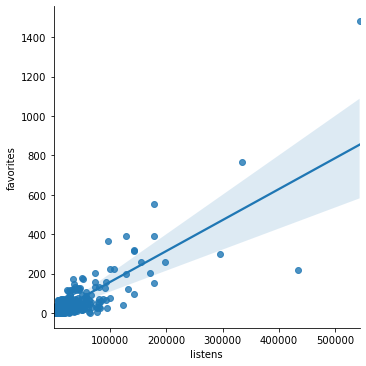

In [16]:
sns.lmplot(x=a,y=b, data=df_regr)

# Pre-processing

In [17]:
train = df_regr.index[df_regr['split'] == 'training']
val = df_regr.index[df_regr['split'] == 'validation']
test = df_regr.index[df_regr['split'] == 'test']

In [18]:
y_train = df_regr[b].loc[df_regr['split'] == 'training']
y_val = df_regr[b].loc[df_regr['split'] == 'validation']
y_test = df_regr[b].loc[df_regr['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

((19922,), (2505,), (2573,))

In [19]:
X=df_regr.drop(b,axis=1)

In [20]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']
X_train.shape, X_val.shape, X_test.shape

((19922, 20), (2505, 20), (2573, 20))

In [21]:
#for plot 2d linear regressor
cut_columns_2d_regr=['split','subset',
            'roll_max','roll_min','roll_skew','roll_mean','roll_median',
            'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew',
            'centr_std','duration','roll_std']
#'roll_std',           
X_train.drop(cut_columns_2d_regr,axis=1,inplace=True)
X_val.drop(cut_columns_2d_regr,axis=1,inplace=True)
X_test.drop(cut_columns_2d_regr,axis=1,inplace=True)

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#normalize data with Robust scaler
scaler = RobustScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_val)
scaler.fit_transform(X_test)

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_val)
scaler.fit_transform(X_test)

array([[-0.07011414, -0.04362238, -0.10119983,  0.00815361],
       [-0.07011414,  0.02170858,  0.26257962, -0.23303591],
       [-0.07011414, -0.05495624, -0.17658378, -0.15417462],
       ...,
       [-0.07011414, -0.03534467, -0.05832088, -0.28516949],
       [-0.07011414, -0.01851281,  0.01689017, -0.06523179],
       [-0.07011414, -0.00079021,  0.09331152, -0.28430115]])

In [22]:
#task:rimuovere l'1% degli outliers:
outlier_fraction = 0.1
#andremo a cercare slamente l'1% degli outliers e li rimuoveremo o sostituiremo in seguito

In [23]:
from pyod.models.abod import ABOD
abod=ABOD(contamination=outlier_fraction)
abod.fit(X_train)
abod_anomalies = abod.predict(X_train)
np.unique(abod_anomalies, return_counts=True)
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outliers= X_train[abod_anomalies==1]
X_train.shape
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outlier= X_train[abod_anomalies==1]
X_train1, y_train1 = X_train.iloc[abod_inlier, :], y_train.iloc[abod_inlier]
# summarize the shape of the updated training dataset
print(X_train1.shape, y_train1.shape)

(17963, 4) (17963,)


In [24]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(max_samples=100,random_state=42, contamination=0.1) 
iso.fit(X_train)
if_anomalies=iso.predict(X_train)
np.unique(if_anomalies,return_counts=True)
# select all rows that are not outliers
if_inlier=if_anomalies!=-1
if_outlier=X_train[if_anomalies==-1]
X_train4, y_train4 = X_train.iloc[if_inlier, :], y_train.iloc[if_inlier]
# summarize the shape of the updated training dataset
print(X_train4.shape, y_train4.shape)

(17929, 4) (17929,)


In [25]:
if_indexes=if_outlier.index.tolist()
abod_indexes=abod_outlier.index.tolist()
#comparison if with abod
count_if_abod=0
for i in set(if_indexes).intersection(set(abod_indexes)):
    count_if_abod= count_if_abod+1
print(count_if_abod) 

1385


In [26]:
X_train_clean=X_train.copy()
y_train_clean=y_train.copy()
for index in set(if_indexes).intersection(set(abod_indexes)):
    X_train_clean.drop(index,inplace=True)
    y_train_clean.drop(index, inplace=True)
print('Dataset before outliers removed:',X_train.shape, y_train.shape)
print('Dataset cleaned:', X_train_clean.shape, y_train_clean.shape)

Dataset before outliers removed: (19922, 4) (19922,)
Dataset cleaned: (18537, 4) (18537,)


In [27]:
X_train=X_train_clean
y_train=y_train_clean
X_train.shape,y_train.shape

((18537, 4), (18537,))

In [28]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [29]:
X_train.head()

,comments,interest,listens,roll_kurtosis
track_id,,,,
81884,0,2296,1940,0.445309
30084,0,1968,833,9.926342
71721,0,2998,2598,19.235535
19181,0,935,824,5.788989
17843,0,884,407,2.068973


In [30]:
multi_reg=LinearRegression()
multi_reg.fit(X_train,y_train)

LinearRegression()

In [31]:
print('Coefficients: \n', multi_reg.coef_)
print('Intercept: \n',multi_reg.intercept_)

Coefficients: 
 [1.52387688e+00 5.22625396e-04 6.76602804e-04 1.76743535e-03]
Intercept: 
 0.09740163552448866


In [32]:
y_pred = multi_reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))

R2: 0.779
MSE: 201.062
MAE: 2.685
Coefficient of determination: 0.78


# LASSO

In [33]:
reg = Lasso()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.         0.00052166 0.00069494 0.00081827]
Intercept: 
 0.11403315919275947


In [34]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.806
MSE: 177.232
MAE: 2.667


# RIDGE

In [35]:
reg = Ridge()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [1.52160555e+00 5.22625587e-04 6.76629888e-04 1.76740849e-03]
Intercept: 
 0.09740844166392737


In [36]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.779
MSE: 201.027
MAE: 2.685
